# Mental Health in Technology-related Jobs

This notebook preprocesses the Mental Health in Tech Survey 2016 dataset to support HR departments in developing targeted mental health intervention programs. The analysis transforms 1,433 raw survey responses from technology workers into a clean, standardized dataset suitable for clustering analysis.

## Importing libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

## Downloading the data

In [3]:
# Load the dataset
df = pd.read_csv("mental-heath-in-tech-2016_20161114.csv")

In [4]:
# Display all column names for review
for i, col in enumerate(df.columns, 1):
    print(f"{i:2d}. {col}")

print(f"\nTotal columns: {len(df.columns)}")

 1. Are you self-employed?
 2. How many employees does your company or organization have?
 3. Is your employer primarily a tech company/organization?
 4. Is your primary role within your company related to tech/IT?
 5. Does your employer provide mental health benefits as part of healthcare coverage?
 6. Do you know the options for mental health care available under your employer-provided coverage?
 7. Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?
 8. Does your employer offer resources to learn more about mental health concerns and options for seeking help?
 9. Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?
10. If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:
11. Do you think that discussing a mental health disorder with your employer would have n

## First look at the data

This section performs initial exploratory data analysis to understand the dataset's structure and identify data quality issues. The code creates a comprehensive overview showing data types, missing value patterns, and unique value counts for each column, sorted by missing percentage to quickly spot problematic features that may need to be dropped or require special handling. Additionally, it analyzes correlations among all feature types (numeric and categorical) to identify highly correlated attribute pairs (correlation ≥ 0.7) that could indicate multicollinearity issues or redundant features. The analysis uses Pearson correlation for numeric-numeric relationships and Cramér's V for categorical associations, which is crucial for clustering algorithms as highly correlated features can bias distance calculations and reduce the effectiveness of unsupervised learning methods.

In [5]:
# Check data types and missing values
print("\n" + "="*50)
print("DATA TYPES & MISSING VALUES")
print("="*50)

missing_info = pd.DataFrame({
    'Column': df.columns,
    'Data_Type': df.dtypes,
    'Missing_Count': df.isnull().sum(),
    'Missing_Percent': (df.isnull().sum() / len(df) * 100).round(2),
    'Unique_Values': [df[col].nunique() for col in df.columns]
})

# Sort by missing percentage (highest first)
missing_info = missing_info.sort_values('Missing_Percent', ascending=False)
print(missing_info.to_string(index=False))


DATA TYPES & MISSING VALUES
                                                                                                                                                                          Column Data_Type  Missing_Count  Missing_Percent  Unique_Values
                                                    If you have revealed a mental health issue to a client or business contact, do you believe this has impacted you negatively?    object           1289            89.95              3
                                            If yes, what percentage of your work time (time performing primary or secondary job functions) is affected by a mental health issue?    object           1229            85.76              4
                                                                                                                    Is your primary role within your company related to tech/IT?   float64           1170            81.65              2
                                   

In [6]:
# Quick peek at the data
print("\n" + "="*50)
print("SAMPLE DATA (First 3 rows)")
print("="*50)
print(df.head(3).to_string())

print(f"\n" + "="*50)
print("KEY STATISTICS")
print("="*50)
print(f"Total responses: {len(df):,}")
print(f"Columns with >50% missing: {(missing_info['Missing_Percent'] > 50).sum()}")
print(f"Completely empty columns: {(missing_info['Missing_Percent'] == 100).sum()}")


SAMPLE DATA (First 3 rows)
   Are you self-employed? How many employees does your company or organization have?  Is your employer primarily a tech company/organization?  Is your primary role within your company related to tech/IT? Does your employer provide mental health benefits as part of healthcare coverage? Do you know the options for mental health care available under your employer-provided coverage? Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)? Does your employer offer resources to learn more about mental health concerns and options for seeking help? Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer? If a mental health issue prompted you to request a medical leave from work, asking for that leave would be: Do you think that discussing a mental health disorder with your employer would have negative con

In [7]:
# Check for highly correlated attributes across all data types
print("\n" + "="*50)
print("HIGHLY CORRELATED ATTRIBUTES")
print("="*50)

# Function to calculate correlation between different variable types
def calculate_mixed_correlation(df, col1, col2):
    """Calculate appropriate correlation based on variable types"""
    from scipy.stats import chi2_contingency, pearsonr
    import warnings
    
    # Get data types
    is_numeric1 = df[col1].dtype in ['int64', 'float64'] or pd.api.types.is_numeric_dtype(df[col1])
    is_numeric2 = df[col2].dtype in ['int64', 'float64'] or pd.api.types.is_numeric_dtype(df[col2])
    
    # Remove missing values for correlation calculation
    clean_data = df[[col1, col2]].dropna()
    
    if len(clean_data) < 10:  # Not enough data
        return None, "insufficient_data"
    
    # Check for constant columns (no variance)
    if clean_data[col1].nunique() <= 1 or clean_data[col2].nunique() <= 1:
        return None, "constant_column"
    
    if is_numeric1 and is_numeric2:
        # Both numeric - use Pearson correlation
        try:
            # Check for zero variance
            if clean_data[col1].std() == 0 or clean_data[col2].std() == 0:
                return None, "zero_variance"
            
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                corr, p_value = pearsonr(clean_data[col1], clean_data[col2])
                
            # Check if correlation is valid
            if np.isnan(corr) or np.isinf(corr):
                return None, "invalid_correlation"
                
            return corr, "pearson"
        except:
            return None, "pearson_error"
    
    else:
        # At least one categorical - use Cramér's V
        try:
            contingency_table = pd.crosstab(clean_data[col1], clean_data[col2])
            
            # Check if contingency table is valid for Cramér's V
            if contingency_table.shape[0] <= 1 or contingency_table.shape[1] <= 1:
                return None, "invalid_contingency"
            
            chi2, p, dof, expected = chi2_contingency(contingency_table)
            n = contingency_table.sum().sum()
            
            # Calculate Cramér's V with proper handling
            min_dim = min(contingency_table.shape) - 1
            if min_dim <= 0 or n <= 0:
                return None, "invalid_dimensions"
                
            cramers_v = np.sqrt(chi2 / (n * min_dim))
            
            # Check if result is valid
            if np.isnan(cramers_v) or np.isinf(cramers_v):
                return None, "invalid_cramers"
                
            return cramers_v, "cramers_v"
        except Exception as e:
            return None, "cramers_error"

# Analyze correlations for a sample of columns (to avoid overwhelming output)
# Focus on key columns that are likely to be important
key_columns = []

# Get numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
key_columns.extend(numeric_cols)

# Get categorical columns with reasonable number of categories (2-10)
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
for col in categorical_cols:
    unique_count = df[col].nunique()
    if 2 <= unique_count <= 10:  # Reasonable range for correlation analysis
        key_columns.append(col)

# Remove duplicates and limit to first 20 columns to keep analysis manageable
key_columns = list(dict.fromkeys(key_columns))[:20]

print(f"Analyzing correlations among {len(key_columns)} key columns:")
print(f"  - Numeric columns: {len(numeric_cols)}")
print(f"  - Selected categorical columns: {len([col for col in key_columns if col in categorical_cols])}")

if len(key_columns) > 1:
    high_corr_pairs = []
    correlation_threshold = 0.7
    
    # Calculate pairwise correlations
    for i in range(len(key_columns)):
        for j in range(i+1, len(key_columns)):
            col1, col2 = key_columns[i], key_columns[j]
            
            # Skip if either column has too many missing values
            if df[col1].isnull().sum() > len(df) * 0.5 or df[col2].isnull().sum() > len(df) * 0.5:
                continue
                
            corr_value, corr_type = calculate_mixed_correlation(df, col1, col2)
            
            if corr_value is not None and abs(corr_value) >= correlation_threshold:
                high_corr_pairs.append({
                    'Feature_1': col1,
                    'Feature_2': col2,
                    'Correlation': corr_value,
                    'Type': corr_type
                })
    
    if high_corr_pairs:
        # Create and display correlation table
        corr_df = pd.DataFrame(high_corr_pairs)
        corr_df['Abs_Correlation'] = abs(corr_df['Correlation'])
        corr_df = corr_df.sort_values('Abs_Correlation', ascending=False)
        
        print(f"\nFound {len(corr_df)} pairs with |correlation| >= {correlation_threshold}:")
        print("-" * 90)
        print(f"{'Feature 1':<35} {'Feature 2':<35} {'Corr':<6} {'Type':<10}")
        print("-" * 90)
        
        for idx, row in corr_df.iterrows():
            f1 = row['Feature_1'][:34] if len(row['Feature_1']) > 34 else row['Feature_1']
            f2 = row['Feature_2'][:34] if len(row['Feature_2']) > 34 else row['Feature_2']
            corr_val = f"{row['Correlation']:.3f}"
            corr_type = row['Type']
            print(f"{f1:<35} {f2:<35} {corr_val:<6} {corr_type:<10}")
        
        # Summary statistics
        print(f"\n📊 Correlation Summary:")
        print(f"   Highest correlation: {corr_df['Correlation'].iloc[0]:.3f}")
        print(f"   Average |correlation|: {corr_df['Abs_Correlation'].mean():.3f}")
        print(f"   Pearson correlations: {(corr_df['Type'] == 'pearson').sum()}")
        print(f"   Cramér's V associations: {(corr_df['Type'] == 'cramers_v').sum()}")
        
        # Warning for very high correlations
        very_high = corr_df[corr_df['Abs_Correlation'] >= 0.9]
        if len(very_high) > 0:
            print(f"   ⚠️  {len(very_high)} pairs with |correlation| >= 0.9 (potential redundancy)")
    else:
        print(f"✅ No highly correlated pairs found (threshold: {correlation_threshold})")
        print("   This suggests good feature independence for clustering analysis.")

else:
    print("⚠️  Insufficient columns for correlation analysis.")

print(f"\n💡 Note: Analysis limited to {len(key_columns)} key columns to keep output manageable.")
print("   Pearson correlation used for numeric-numeric pairs.")
print("   Cramér's V used for categorical associations.")
print("\n" + "="*50)


HIGHLY CORRELATED ATTRIBUTES
Analyzing correlations among 20 key columns:
  - Numeric columns: 7
  - Selected categorical columns: 13
✅ No highly correlated pairs found (threshold: 0.7)
   This suggests good feature independence for clustering analysis.

💡 Note: Analysis limited to 20 key columns to keep output manageable.
   Pearson correlation used for numeric-numeric pairs.
   Cramér's V used for categorical associations.



## Cleaning the data

This section performs three key data cleaning operations: geographic filtering to focus on US-based respondents only (both living and working in the US), age cleaning to convert to numeric values and filter to a reasonable range (18-80), and gender standardization to consolidate various text inputs into three consistent categories (Male, Female, Other). These steps reduce the dataset from 1,433 to 835 clean, relevant responses while ensuring data consistency for analysis.

In [8]:
# Filter to US-based respondents only
print("GEOGRAPHIC FILTERING")
print("="*50)

# Define US aliases
us_aliases = {"united states", "united states of america", "usa", "us"}

# Check unique country values first
print("Unique countries (live):")
live_countries = df["What country do you live in?"].value_counts()
print(live_countries.head(10))

print("\nUnique countries (work):")
work_countries = df["What country do you work in?"].value_counts()
print(work_countries.head(10))

# Create masks for US-based respondents
mask_live_us = (
    df["What country do you live in?"]
    .str.lower()
    .str.strip()
    .isin(us_aliases)
)

mask_work_us = (
    df["What country do you work in?"]
    .str.lower()
    .str.strip()
    .isin(us_aliases)
)

# Combine both conditions
us_mask = mask_live_us & mask_work_us

print(f"\nFiltering results:")
print(f"Live in US: {mask_live_us.sum():,}")
print(f"Work in US: {mask_work_us.sum():,}")
print(f"Both live AND work in US: {us_mask.sum():,}")

# Apply filter
df_us = df.loc[us_mask].copy().reset_index(drop=True)
print(f"\nFinal dataset size: {len(df_us):,} rows")

GEOGRAPHIC FILTERING
Unique countries (live):
What country do you live in?
United States of America    840
United Kingdom              180
Canada                       78
Germany                      58
Netherlands                  48
Australia                    35
Sweden                       19
France                       16
Ireland                      15
Switzerland                  10
Name: count, dtype: int64

Unique countries (work):
What country do you work in?
United States of America    851
United Kingdom              183
Canada                       74
Germany                      58
Netherlands                  47
Australia                    34
Sweden                       20
Ireland                      15
France                       14
Switzerland                  10
Name: count, dtype: int64

Filtering results:
Live in US: 840
Work in US: 851
Both live AND work in US: 837

Final dataset size: 837 rows


In [9]:
# Clean age column
print("\nAGE CLEANING")
print("="*30)

# Check current age values
print("Age statistics before cleaning:")
print(df_us["What is your age?"].describe())
print(f"\nUnique age values: {sorted(df_us['What is your age?'].unique())}")

# Convert to numeric and filter reasonable ages
df_us['age_clean'] = pd.to_numeric(df_us["What is your age?"], errors='coerce')

# Filter to reasonable age range (18-80)
age_mask = df_us['age_clean'].between(18, 80, inclusive='both')
print(f"\nAge filtering:")
print(f"Valid ages (18-80): {age_mask.sum():,}")
print(f"Invalid/missing ages: {(~age_mask).sum():,}")

# Apply age filter
df_us = df_us.loc[age_mask].copy().reset_index(drop=True)
print(f"Dataset size after age filtering: {len(df_us):,}")


AGE CLEANING
Age statistics before cleaning:
count    837.000000
mean      34.948626
std       13.303541
min       19.000000
25%       29.000000
50%       33.000000
75%       39.000000
max      323.000000
Name: What is your age?, dtype: float64

Unique age values: [19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 61, 62, 63, 65, 66, 70, 74, 99, 323]

Age filtering:
Valid ages (18-80): 835
Invalid/missing ages: 2
Dataset size after age filtering: 835


In [10]:
# Clean gender column
print("\nGENDER CLEANING")
print("="*30)

# Check current gender values
print("Original gender values:")
gender_counts = df_us["What is your gender?"].value_counts()
print(gender_counts)

def clean_gender(gender_val):
    """Standardize gender values to Male, Female, Other"""
    if pd.isna(gender_val):
        return 'Other'
    
    gender_str = str(gender_val).strip().lower()
    
    # Male patterns
    if gender_str in ['male', 'm', 'man', 'cis male', 'cis man', 'cisgender male', 'dude']:
        return 'Male'
    
    # Female patterns  
    if gender_str in ['female', 'f', 'woman', 'cis female', 'cis woman', 'cisgender female']:
        return 'Female'
    
    # Check for partial matches
    if 'male' in gender_str and 'female' not in gender_str:
        return 'Male'
    if 'female' in gender_str or 'woman' in gender_str:
        return 'Female'
    
    return 'Other'

# Apply gender cleaning
df_us['gender_clean'] = df_us["What is your gender?"].apply(clean_gender)

print(f"\nCleaned gender distribution:")
print(df_us['gender_clean'].value_counts())


GENDER CLEANING
Original gender values:
What is your gender?
Male                                                       332
male                                                       129
Female                                                     110
female                                                      70
M                                                           48
m                                                           41
F                                                           31
f                                                           15
Female                                                       7
Male                                                         4
woman                                                        4
Woman                                                        3
Male (cis)                                                   2
female                                                       2
non-binary                                              

## Feature selection

This section removes irrelevant columns and simplifies column names for analysis. The code drops free text responses, geographic columns (already filtered), columns with >80% missing values, and redundant columns, reducing from 63 to 43 features. It then renames the remaining columns from long survey questions to shorter, manageable variable names (e.g., "Are you self-employed?" becomes "self_employed") to improve code readability and processing efficiency.

In [11]:
print("FEATURE SELECTION")
print("="*50)

# Identify columns to drop (high missing values, free text, redundant)
cols_to_drop = [
    # Free text responses (not useful for clustering)
    "Why or why not?",
    "Why or why not?.1",
    "If yes, what condition(s) have you been diagnosed with?",
    "If so, what condition(s) were you diagnosed with?",
    "If maybe, what condition(s) do you believe you have?",
    "Which of the following best describes your work position?",
    
    # Geographic columns (already filtered)
    "What country do you live in?",
    "What country do you work in?", 
    "What US state or territory do you live in?",
    "What US state or territory do you work in?",
    
    # Very high missing values (>80% missing)
    "If you have revealed a mental health issue to a client or business contact, do you believe this has impacted you negatively?",
    "If yes, what percentage of your work time (time performing primary or secondary job functions) is affected by a mental health issue?",
    "Is your primary role within your company related to tech/IT?",
    "Do you know local or online resources to seek help for a mental health disorder?",
    "Do you have medical coverage (private insurance or state-provided) which includes treatment of  mental health issues?",
    "Do you believe your productivity is ever affected by a mental health issue?",
    "If you have revealed a mental health issue to a coworker or employee, do you believe this has impacted you negatively?",
    "If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to coworkers or employees?",
    "If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to clients or business contacts?",
    
    # Redundant with our cleaned versions
    "What is your age?",
    "What is your gender?",
]

# Create feature-selected dataset
df_features = df_us.drop(columns=cols_to_drop, errors='ignore').copy()

print(f"Columns dropped: {len(cols_to_drop)}")
print(f"Remaining columns: {df_features.shape[1]}")
print(f"Dataset shape: {df_features.shape}")

FEATURE SELECTION
Columns dropped: 21
Remaining columns: 45
Dataset shape: (835, 45)


In [12]:
# Rename columns to shorter, more manageable names
rename_dict = {
    "Are you self-employed?": "self_employed",
    "How many employees does your company or organization have?": "company_size",
    "Is your employer primarily a tech company/organization?": "is_tech_company",
    "Does your employer provide mental health benefits as part of healthcare coverage?": "mh_benefits",
    "Do you know the options for mental health care available under your employer-provided coverage?": "mh_coverage_knowledge",
    "Do you have medical coverage (private insurance or state-provided) which includes treatment of \xa0mental health issues?": "mh_cov_Insurance",
    "Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?": "employer_mh_discussion",
    "Does your employer offer resources to learn more about mental health concerns and options for seeking help?": "employer_mh_resources",
    "Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?": "anonymity_protected",
    "If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:": "leave_difficulty",
    "Do you think that discussing a mental health disorder with your employer would have negative consequences?": "employer_mh_consequences",
    "Do you think that discussing a physical health issue with your employer would have negative consequences?": "employer_ph_consequences",
    "Would you feel comfortable discussing a mental health disorder with your coworkers?": "coworker_mh_comfort",
    "Would you feel comfortable discussing a mental health disorder with your direct supervisor(s)?": "supervisor_mh_comfort",
    "Do you feel that your employer takes mental health as seriously as physical health?": "mh_ph_equality",
    "Have you heard of or observed negative consequences for co-workers who have been open about mental health issues in your workplace?": "observed_consequences",
    "Do you have previous employers?": "has_prev_employers",
    "Have your previous employers provided mental health benefits?": "prev_mh_benefits",
    "Were you aware of the options for mental health care provided by your previous employers?": "prev_mh_coverage_knowledge",
    "Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?": "prev_employer_mh_discussion",
    "Did your previous employers provide resources to learn more about mental health issues and how to seek help?": "prev_employer_mh_resources",
    "Was your anonymity protected if you chose to take advantage of mental health or substance abuse treatment resources with previous employers?": "prev_anonymity_protected",
    "Do you think that discussing a mental health disorder with previous employers would have negative consequences?": "prev_employer_mh_consequences",
    "Do you think that discussing a physical health issue with previous employers would have negative consequences?": "prev_employer_ph_consequences",
    "Would you have been willing to discuss a mental health issue with your previous co-workers?": "prev_coworker_mh_willingness",
    "Would you have been willing to discuss a mental health issue with your direct supervisor(s)?": "prev_supervisor_mh_willingness",
    "Did you feel that your previous employers took mental health as seriously as physical health?": "prev_mh_ph_equality",
    "Did you hear of or observe negative consequences for co-workers with mental health issues in your previous workplaces?": "prev_observed_consequences",
    "Would you be willing to bring up a physical health issue with a potential employer in an interview?": "interview_ph_discussion",
    "Would you bring up a mental health issue with a potential employer in an interview?": "interview_mh_discussion",
    "Do you feel that being identified as a person with a mental health issue would hurt your career?": "mh_hurt_career",
    "Do you think that team members/co-workers would view you more negatively if they knew you suffered from a mental health issue?": "coworkers_negative_view",
    "How willing would you be to share with friends and family that you have a mental illness?": "family_sharing_willingness",
    "Have you observed or experienced an unsupportive or badly handled response to a mental health issue in your current or previous workplace?": "unsupportive_response",
    "Have your observations of how another individual who discussed a mental health disorder made you less likely to reveal a mental health issue yourself in your current workplace?": "discouraged_by_others",
    "Do you have a family history of mental illness?": "family_history_mh",
    "Have you had a mental health disorder in the past?": "past_mh_disorder",
    "Do you currently have a mental health disorder?": "current_mh_disorder",
    "Have you been diagnosed with a mental health condition by a medical professional?": "professionally_diagnosed",
    "Have you ever sought treatment for a mental health issue from a mental health professional?": "sought_treatment",
    "If you have a mental health issue, do you feel that it interferes with your work when being treated effectively?": "work_interference_treated",
    "If you have a mental health issue, do you feel that it interferes with your work when NOT being treated effectively?": "work_interference_untreated",
    "Do you work remotely?": "work_remotely"
}

# Apply renaming
df_features.rename(columns=rename_dict, inplace=True)

print("\nColumn renaming completed")
print(f"Final feature columns: {df_features.shape[1]}")


Column renaming completed
Final feature columns: 45


## Handling missing values

This section implements a tiered strategy for missing value treatment based on data sparsity levels. Columns with >80% missing are dropped as they provide insufficient information, while columns with 50-80% missing are also dropped to avoid unreliable imputation. For remaining missing values, the code uses SimpleImputer with mode (most frequent value) for categorical variables and median for numeric variables - these methods are robust to outliers and preserve the original data distribution better than mean imputation, which is crucial for maintaining meaningful patterns in clustering analysis.

In [13]:
# Check missing values in our selected features
print("\nMISSING VALUES IN SELECTED FEATURES")
print("="*50)

missing_summary = pd.DataFrame({
    'Column': df_features.columns,
    'Missing_Count': df_features.isnull().sum(),
    'Missing_Percent': (df_features.isnull().sum() / len(df_features) * 100).round(2)
})

# Sort by missing percentage
missing_summary = missing_summary.sort_values('Missing_Percent', ascending=False)
missing_summary = missing_summary[missing_summary['Missing_Count'] > 0]

print(missing_summary.to_string(index=False))
print(f"\nColumns with missing values: {len(missing_summary)}")
print(f"Maximum missing percentage: {missing_summary['Missing_Percent'].max():.1f}%")


MISSING VALUES IN SELECTED FEATURES
                        Column  Missing_Count  Missing_Percent
              mh_cov_Insurance            706            84.55
         discouraged_by_others            447            53.53
         mh_coverage_knowledge            155            18.56
           coworker_mh_comfort            129            15.45
      employer_ph_consequences            129            15.45
         observed_consequences            129            15.45
                mh_ph_equality            129            15.45
         supervisor_mh_comfort            129            15.45
                  company_size            129            15.45
      employer_mh_consequences            129            15.45
              leave_difficulty            129            15.45
           anonymity_protected            129            15.45
         employer_mh_resources            129            15.45
        employer_mh_discussion            129            15.45
                  

In [14]:
print("MISSING VALUE HANDLING STRATEGY")
print("="*50)

# Drop columns with extremely high missing values (>80%)
high_missing_cols = ['mh_cov_Insurance']  # 84.55% missing
print(f"Dropping columns with >80% missing: {high_missing_cols}")

df_features = df_features.drop(columns=high_missing_cols)

# Drop the discouraged_by_others column (53% missing, too high for reliable imputation)
moderate_missing_cols = ['discouraged_by_others']  # 53.53% missing
print(f"Dropping columns with >50% missing: {moderate_missing_cols}")

df_features = df_features.drop(columns=moderate_missing_cols)

print(f"Dataset shape after dropping high-missing columns: {df_features.shape}")

MISSING VALUE HANDLING STRATEGY
Dropping columns with >80% missing: ['mh_cov_Insurance']
Dropping columns with >50% missing: ['discouraged_by_others']
Dataset shape after dropping high-missing columns: (835, 43)


In [15]:
# Handle remaining missing values with appropriate imputation
print("\nIMPUTING REMAINING MISSING VALUES")
print("="*40)

# Check what we're working with now
remaining_missing = df_features.isnull().sum()
remaining_missing = remaining_missing[remaining_missing > 0].sort_values(ascending=False)
print("Remaining missing values:")
print(remaining_missing)

# Strategy: Use mode (most frequent value) for categorical variables
from sklearn.impute import SimpleImputer

# Separate numeric and categorical columns
numeric_cols = df_features.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df_features.select_dtypes(include=['object']).columns.tolist()

print(f"\nNumeric columns: {len(numeric_cols)}")
print(f"Categorical columns: {len(categorical_cols)}")

# Impute categorical columns with mode
cat_imputer = SimpleImputer(strategy='most_frequent')
if categorical_cols:
    df_features[categorical_cols] = cat_imputer.fit_transform(df_features[categorical_cols])

# Impute numeric columns with median  
num_imputer = SimpleImputer(strategy='median')
if numeric_cols:
    df_features[numeric_cols] = num_imputer.fit_transform(df_features[numeric_cols])

# Verify no missing values remain
total_missing = df_features.isnull().sum().sum()
print(f"\nTotal missing values after imputation: {total_missing}")


IMPUTING REMAINING MISSING VALUES
Remaining missing values:
mh_coverage_knowledge             155
company_size                      129
employer_mh_consequences          129
is_tech_company                   129
mh_ph_equality                    129
supervisor_mh_comfort             129
coworker_mh_comfort               129
employer_ph_consequences          129
observed_consequences             129
leave_difficulty                  129
employer_mh_resources             129
employer_mh_discussion            129
mh_benefits                       129
anonymity_protected               129
prev_employer_ph_consequences      85
prev_observed_consequences         85
prev_mh_ph_equality                85
prev_supervisor_mh_willingness     85
prev_coworker_mh_willingness       85
prev_employer_mh_resources         85
prev_employer_mh_consequences      85
prev_anonymity_protected           85
prev_employer_mh_discussion        85
prev_mh_coverage_knowledge         85
prev_mh_benefits           

In [16]:
# Display final feature summary
print("FINAL FEATURE DATASET SUMMARY")
print("="*40)
print(f"Shape: {df_features.shape}")
print(f"Total missing values: {df_features.isnull().sum().sum()}")

print(f"\nData types:")
print(df_features.dtypes.value_counts())

print(f"\nSample of cleaned data:")
print(df_features.head(3))

# Save checkpoint
df_features.to_csv("mental_health_features_cleaned.csv", index=False)
df_features.to_excel("mental_health_features_cleaned.xlsx", index=False)
print(f"\n✅ Saved cleaned features to 'mental_health_features_cleaned.csv'")

FINAL FEATURE DATASET SUMMARY
Shape: (835, 43)
Total missing values: 0

Data types:
object     38
float64     5
Name: count, dtype: int64

Sample of cleaned data:
   self_employed company_size  is_tech_company   mh_benefits  \
0            0.0         6-25              1.0            No   
1            0.0         6-25              0.0           Yes   
2            0.0       26-100              1.0  I don't know   

  mh_coverage_knowledge employer_mh_discussion employer_mh_resources  \
0                   Yes                    Yes                   Yes   
1                   Yes                     No                    No   
2                    No                     No                    No   

  anonymity_protected            leave_difficulty employer_mh_consequences  \
0                 Yes               Somewhat easy                       No   
1                  No  Neither easy nor difficult                      Yes   
2        I don't know               Somewhat easy        

## Exploratory data analysis (EDA)

This section explores the cleaned mental health survey dataset through four key areas: demographics and employment characteristics, current employer mental health support, personal and family mental health history, and workplace perceptions and attitudes. The visualizations reveal patterns in mental health support, treatment accessibility, and workplace stigma that will inform the clustering analysis for targeted HR interventions.

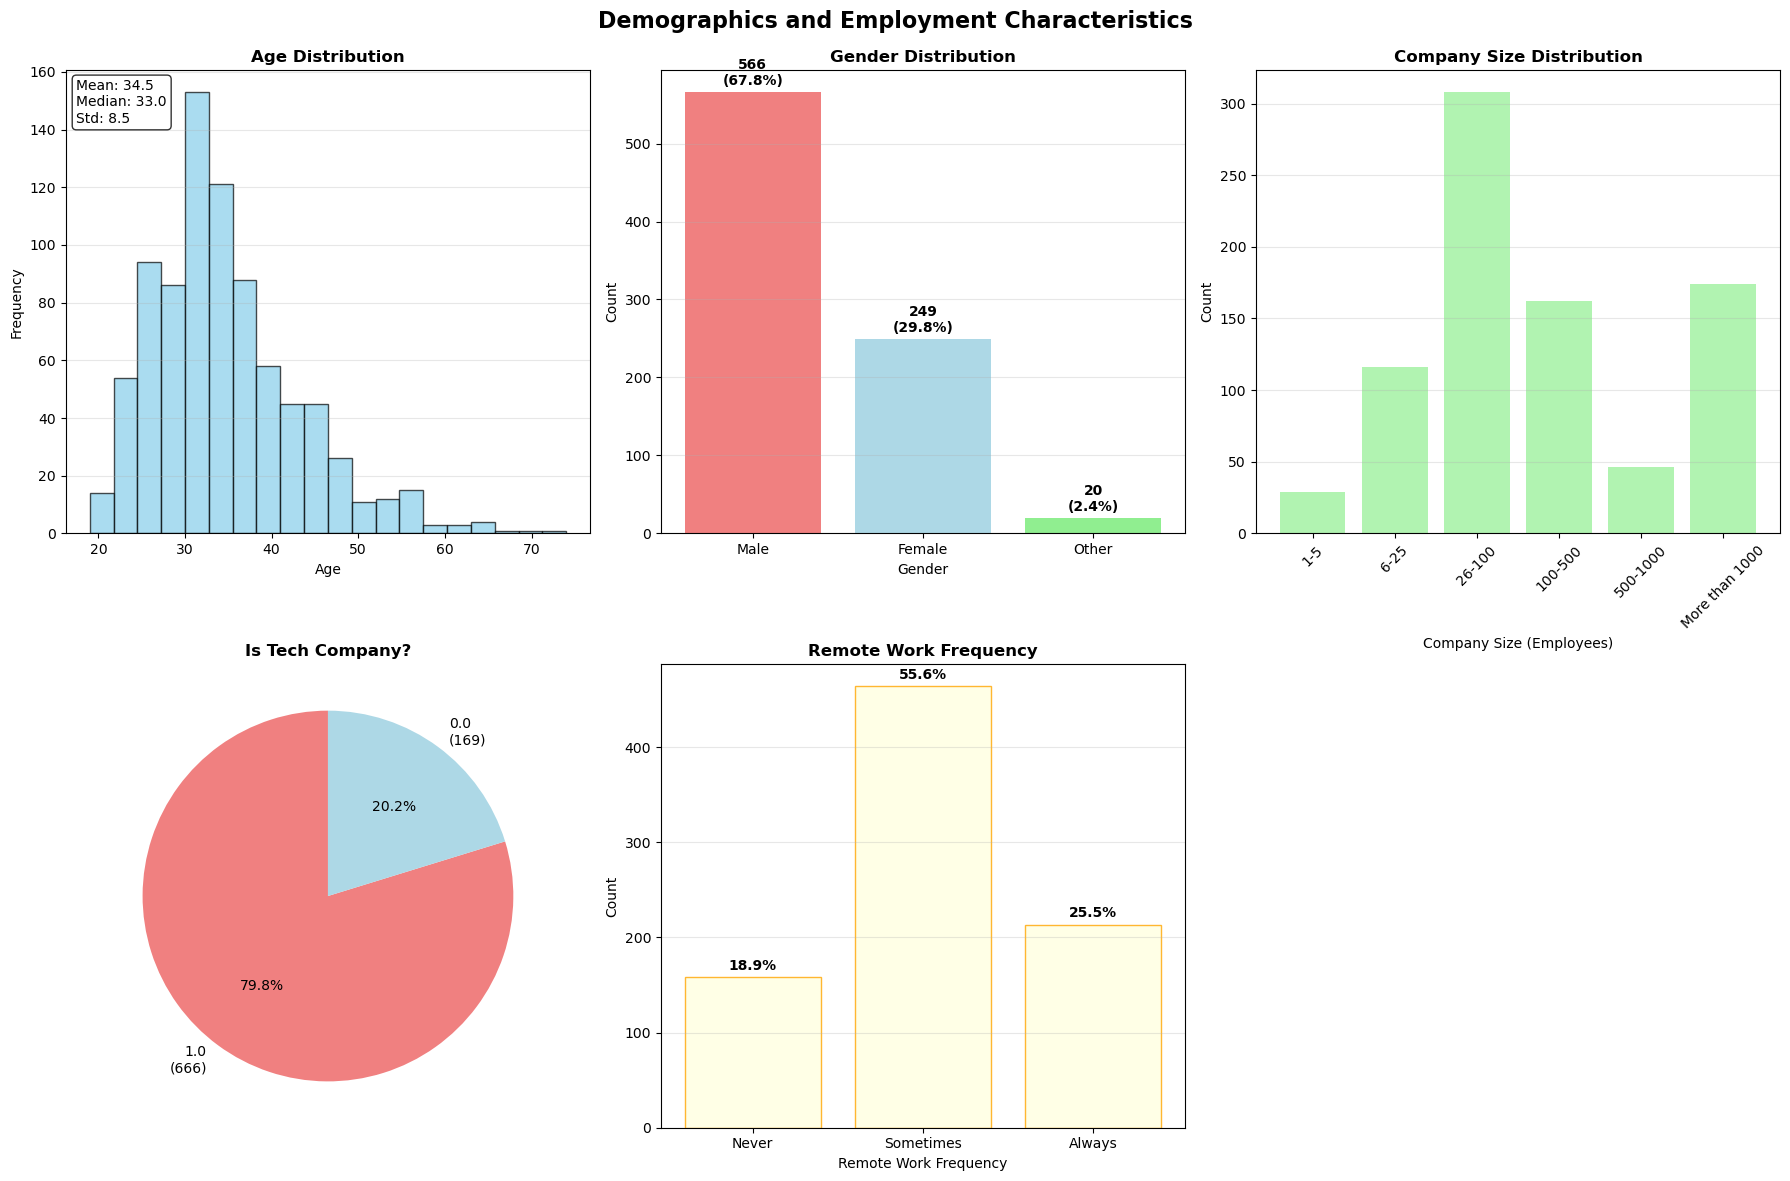

DEMOGRAPHICS AND EMPLOYMENT SUMMARY
Total respondents: 835
Age range: 19 - 74 years
Average age: 34.5 years
Tech company employees: 666 (79.8%)
Remote workers (sometimes/always): 677 (81.1%)


In [17]:
# Demographics and Employment Characteristics

# This section explores the demographic profile and employment characteristics of survey respondents to understand the composition of our dataset.

# Set up the plotting area for demographics
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Demographics and Employment Characteristics', fontsize=16, fontweight='bold')

# 1. Age Distribution
axes[0, 0].hist(df_features['age_clean'], bins=20, color='skyblue', alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Age Distribution', fontweight='bold')
axes[0, 0].set_xlabel('Age')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(axis='y', alpha=0.3)

# Add age statistics as text
age_stats = f"Mean: {df_features['age_clean'].mean():.1f}\nMedian: {df_features['age_clean'].median():.1f}\nStd: {df_features['age_clean'].std():.1f}"
axes[0, 0].text(0.02, 0.98, age_stats, transform=axes[0, 0].transAxes, fontsize=10, 
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 2. Gender Distribution
gender_counts = df_features['gender_clean'].value_counts()
bars = axes[0, 1].bar(gender_counts.index, gender_counts.values, color=['lightcoral', 'lightblue', 'lightgreen'])
axes[0, 1].set_title('Gender Distribution', fontweight='bold')
axes[0, 1].set_xlabel('Gender')
axes[0, 1].set_ylabel('Count')
axes[0, 1].grid(axis='y', alpha=0.3)

# Add percentage labels on bars
for bar, count in zip(bars, gender_counts.values):
    percentage = (count / len(df_features)) * 100
    axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
                    f'{count}\n({percentage:.1f}%)', ha='center', va='bottom', fontweight='bold')

# 3. Company Size Distribution
company_size_counts = df_features['company_size'].value_counts()
# Sort by company size order for better visualization
size_order = ["1-5", "6-25", "26-100", "100-500", "500-1000", "More than 1000"]
company_size_counts = company_size_counts.reindex([size for size in size_order if size in company_size_counts.index])

axes[0, 2].bar(range(len(company_size_counts)), company_size_counts.values, color='lightgreen', alpha=0.7)
axes[0, 2].set_title('Company Size Distribution', fontweight='bold')
axes[0, 2].set_xlabel('Company Size (Employees)')
axes[0, 2].set_ylabel('Count')
axes[0, 2].set_xticks(range(len(company_size_counts)))
axes[0, 2].set_xticklabels(company_size_counts.index, rotation=45)
axes[0, 2].grid(axis='y', alpha=0.3)

# 4. Tech Company Distribution
tech_counts = df_features['is_tech_company'].value_counts()
colors = ['lightcoral', 'lightblue']

pie = axes[1, 0].pie(tech_counts.values, labels=[f'{label}\n({count})' for label, count in zip(tech_counts.index, tech_counts.values)], 
                     autopct='%1.1f%%', colors=colors, startangle=90)
axes[1, 0].set_title('Is Tech Company?', fontweight='bold')

# 5. Remote Work Distribution
remote_counts = df_features['work_remotely'].value_counts()
# Ensure proper order for remote work
remote_order = ["Never", "Sometimes", "Always"]
remote_counts = remote_counts.reindex([remote for remote in remote_order if remote in remote_counts.index])

bars = axes[1, 1].bar(remote_counts.index, remote_counts.values, color='lightyellow', alpha=0.8, edgecolor='orange')
axes[1, 1].set_title('Remote Work Frequency', fontweight='bold')
axes[1, 1].set_xlabel('Remote Work Frequency')
axes[1, 1].set_ylabel('Count')
axes[1, 1].grid(axis='y', alpha=0.3)

# Add percentage labels on bars
for bar, count in zip(bars, remote_counts.values):
    percentage = (count / len(df_features)) * 100
    axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
                    f'{percentage:.1f}%', ha='center', va='bottom', fontweight='bold')

# Hide the empty subplot
axes[1, 2].axis('off')

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.savefig('DEMOGRAPHICS.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics
print("DEMOGRAPHICS AND EMPLOYMENT SUMMARY")
print("="*50)
print(f"Total respondents: {len(df_features):,}")
print(f"Age range: {df_features['age_clean'].min():.0f} - {df_features['age_clean'].max():.0f} years")
print(f"Average age: {df_features['age_clean'].mean():.1f} years")
tech_yes_count = (df_features['is_tech_company'] == df_features['is_tech_company'].unique()[0]).sum()
print(f"Tech company employees: {tech_yes_count:,} ({tech_yes_count/len(df_features)*100:.1f}%)")
print(f"Remote workers (sometimes/always): {(df_features['work_remotely'].isin(['Sometimes', 'Always'])).sum():,} ({(df_features['work_remotely'].isin(['Sometimes', 'Always'])).mean()*100:.1f}%)")

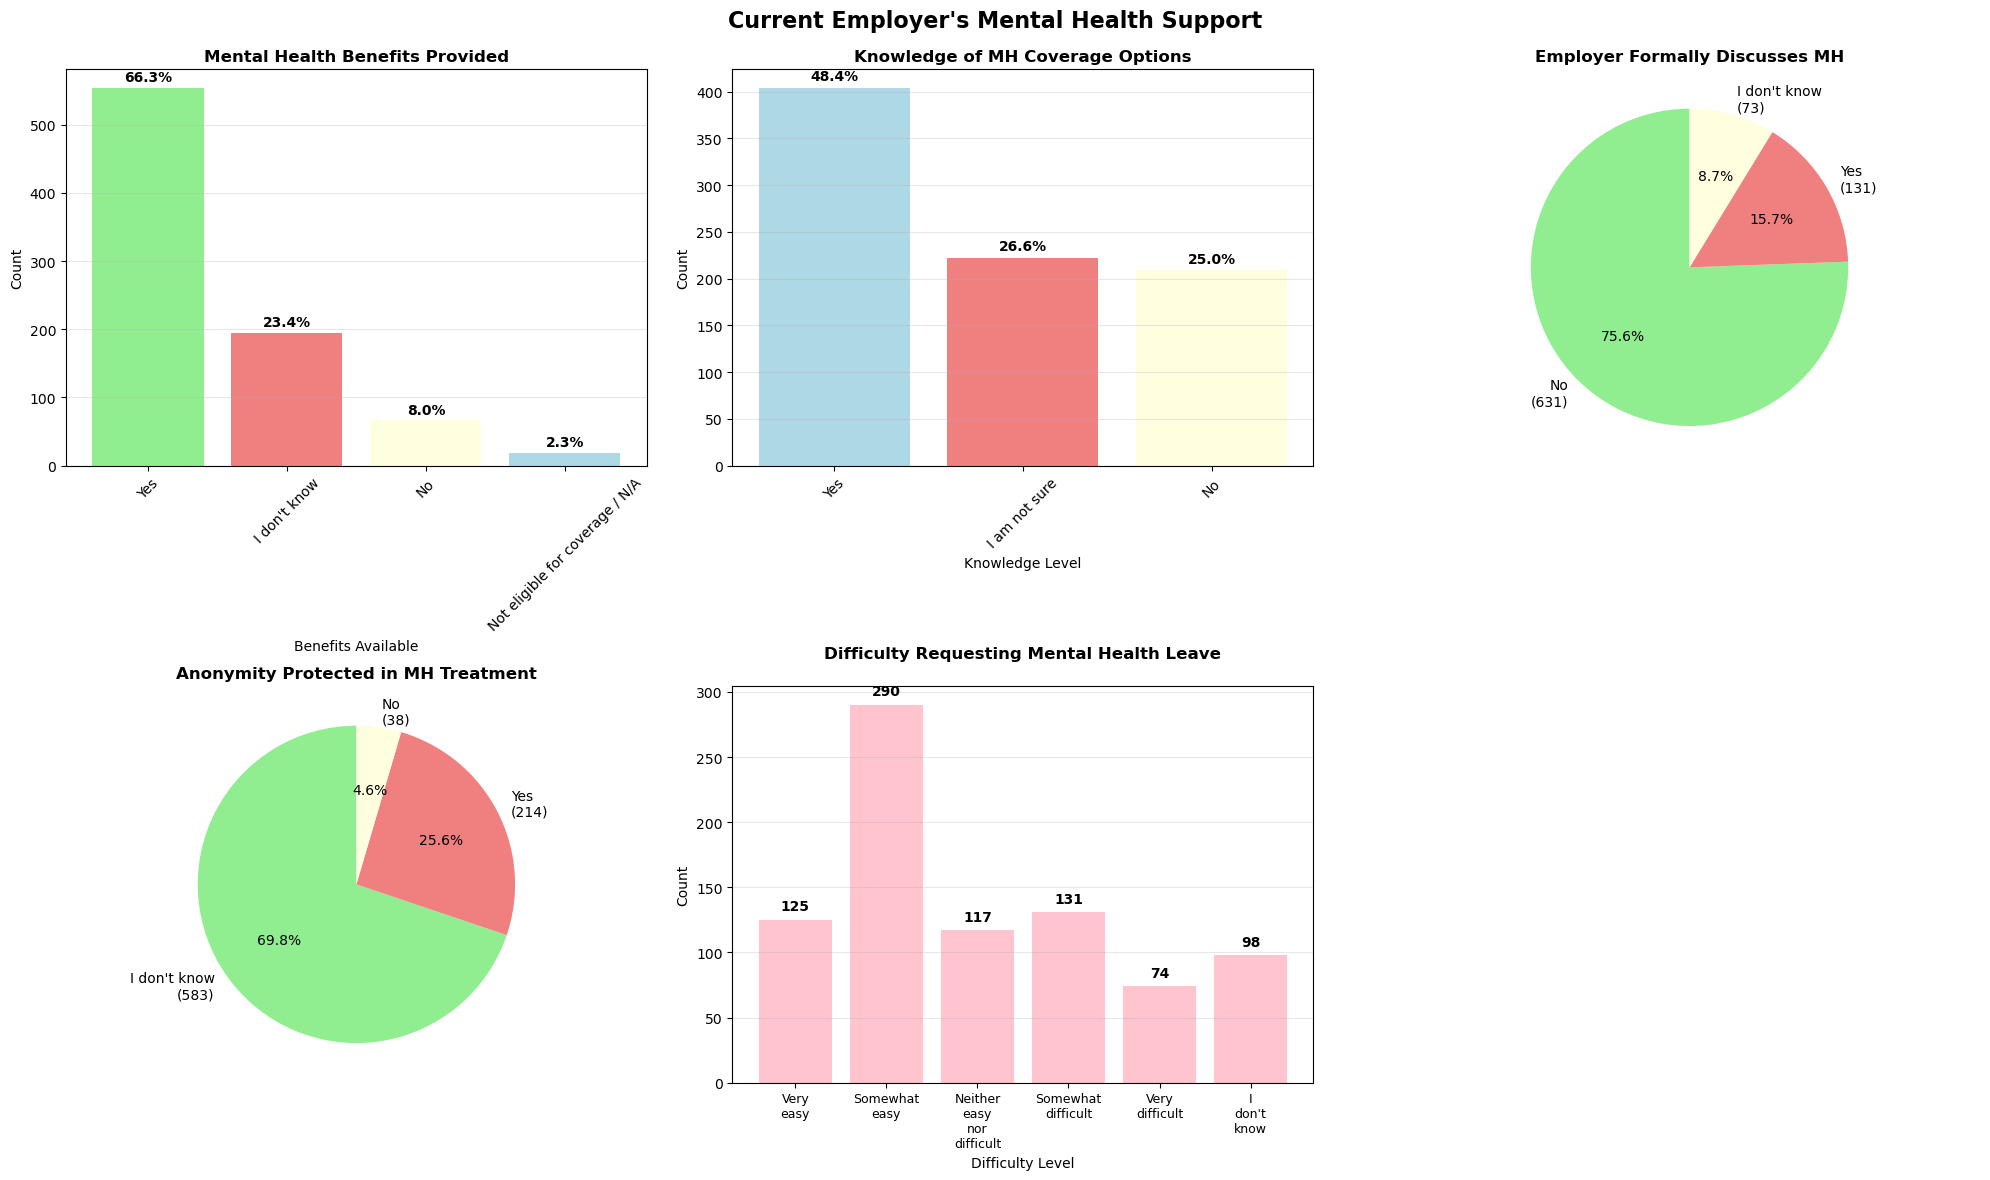


MENTAL HEALTH SUPPORT SUMMARY
Employers providing MH benefits:
  Yes: 554 (66.3%)
  No: 67 (8.0%)

Employers discussing MH formally:
  Yes: 131 (15.7%)
  No: 631 (75.6%)

Anonymity protection in MH treatment:
  Yes: 214 (25.6%)
  No: 38 (4.6%)

Most common leave difficulty: Somewhat easy


In [18]:
# Current Employer's Mental Health Support

# This section examines how well current employers support mental health through benefits, resources, and workplace policies.

# Set up the plotting area for mental health support
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Current Employer\'s Mental Health Support', fontsize=16, fontweight='bold')

# 1. Mental Health Benefits
mh_benefits_counts = df_features['mh_benefits'].value_counts()
colors_benefits = ['lightgreen', 'lightcoral', 'lightyellow','lightblue']
bars1 = axes[0, 0].bar(mh_benefits_counts.index, mh_benefits_counts.values, 
                       color=colors_benefits[:len(mh_benefits_counts)])
axes[0, 0].set_title('Mental Health Benefits Provided', fontweight='bold')
axes[0, 0].set_xlabel('Benefits Available')
axes[0, 0].set_ylabel('Count')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(axis='y', alpha=0.3)

# Add percentage labels on bars
for bar, count in zip(bars1, mh_benefits_counts.values):
    percentage = (count / len(df_features)) * 100
    axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
                    f'{percentage:.1f}%', ha='center', va='bottom', fontweight='bold')

# 2. Mental Health Coverage Knowledge
mh_knowledge_counts = df_features['mh_coverage_knowledge'].value_counts()
colors_knowledge = ['lightblue', 'lightcoral', 'lightyellow']
bars2 = axes[0, 1].bar(mh_knowledge_counts.index, mh_knowledge_counts.values, 
                       color=colors_knowledge[:len(mh_knowledge_counts)])
axes[0, 1].set_title('Knowledge of MH Coverage Options', fontweight='bold')
axes[0, 1].set_xlabel('Knowledge Level')
axes[0, 1].set_ylabel('Count')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(axis='y', alpha=0.3)

# Add percentage labels on bars
for bar, count in zip(bars2, mh_knowledge_counts.values):
    percentage = (count / len(df_features)) * 100
    axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
                    f'{percentage:.1f}%', ha='center', va='bottom', fontweight='bold')

# 3. Employer Mental Health Discussion
mh_discussion_counts = df_features['employer_mh_discussion'].value_counts()
colors_discussion = ['lightgreen', 'lightcoral', 'lightyellow']
pie1 = axes[0, 2].pie(mh_discussion_counts.values, 
                      labels=[f'{label}\n({count})' for label, count in zip(mh_discussion_counts.index, mh_discussion_counts.values)], 
                      autopct='%1.1f%%', colors=colors_discussion[:len(mh_discussion_counts)], startangle=90)
axes[0, 2].set_title('Employer Formally Discusses MH', fontweight='bold')

# 4. Anonymity Protection
anonymity_counts = df_features['anonymity_protected'].value_counts()
colors_anonymity = ['lightgreen', 'lightcoral', 'lightyellow']
pie2 = axes[1, 0].pie(anonymity_counts.values, 
                      labels=[f'{label}\n({count})' for label, count in zip(anonymity_counts.index, anonymity_counts.values)], 
                      autopct='%1.1f%%', colors=colors_anonymity[:len(anonymity_counts)], startangle=90)
axes[1, 0].set_title('Anonymity Protected in MH Treatment', fontweight='bold')

# 5. Leave Difficulty
leave_counts = df_features['leave_difficulty'].value_counts()
# Order from easiest to most difficult for better visualization
difficulty_order = ["Very easy", "Somewhat easy", "Neither easy nor difficult", 
                   "Somewhat difficult", "Very difficult", "I don't know"]
leave_counts_ordered = leave_counts.reindex([diff for diff in difficulty_order if diff in leave_counts.index])

bars3 = axes[1, 1].bar(range(len(leave_counts_ordered)), leave_counts_ordered.values, 
                       color='lightpink', alpha=0.8)
axes[1, 1].set_title('Difficulty Requesting Mental Health Leave', fontweight='bold', y=1.05)
axes[1, 1].set_xlabel('Difficulty Level')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_xticks(range(len(leave_counts_ordered)))
axes[1, 1].set_xticklabels([label.replace(' ', '\n') for label in leave_counts_ordered.index], fontsize=9)
axes[1, 1].grid(axis='y', alpha=0.3)

# Add count labels on bars
for i, (bar, count) in enumerate(zip(bars3, leave_counts_ordered.values)):
    axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
                    f'{count}', ha='center', va='bottom', fontweight='bold')

# Hide the empty subplot
axes[1, 2].axis('off')

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.savefig('MHSUPPORT.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics
print("\nMENTAL HEALTH SUPPORT SUMMARY")
print("="*50)
print(f"Employers providing MH benefits:")
mh_yes = (df_features['mh_benefits'] == 'Yes').sum() if 'Yes' in df_features['mh_benefits'].unique() else 0
mh_no = (df_features['mh_benefits'] == 'No').sum() if 'No' in df_features['mh_benefits'].unique() else 0
print(f"  Yes: {mh_yes:,} ({mh_yes/len(df_features)*100:.1f}%)")
print(f"  No: {mh_no:,} ({mh_no/len(df_features)*100:.1f}%)")

print(f"\nEmployers discussing MH formally:")
disc_yes = (df_features['employer_mh_discussion'] == 'Yes').sum() if 'Yes' in df_features['employer_mh_discussion'].unique() else 0
disc_no = (df_features['employer_mh_discussion'] == 'No').sum() if 'No' in df_features['employer_mh_discussion'].unique() else 0
print(f"  Yes: {disc_yes:,} ({disc_yes/len(df_features)*100:.1f}%)")
print(f"  No: {disc_no:,} ({disc_no/len(df_features)*100:.1f}%)")

print(f"\nAnonymity protection in MH treatment:")
anon_yes = (df_features['anonymity_protected'] == 'Yes').sum() if 'Yes' in df_features['anonymity_protected'].unique() else 0
anon_no = (df_features['anonymity_protected'] == 'No').sum() if 'No' in df_features['anonymity_protected'].unique() else 0
print(f"  Yes: {anon_yes:,} ({anon_yes/len(df_features)*100:.1f}%)")
print(f"  No: {anon_no:,} ({anon_no/len(df_features)*100:.1f}%)")

print(f"\nMost common leave difficulty: {df_features['leave_difficulty'].mode().iloc[0] if not df_features['leave_difficulty'].mode().empty else 'N/A'}")

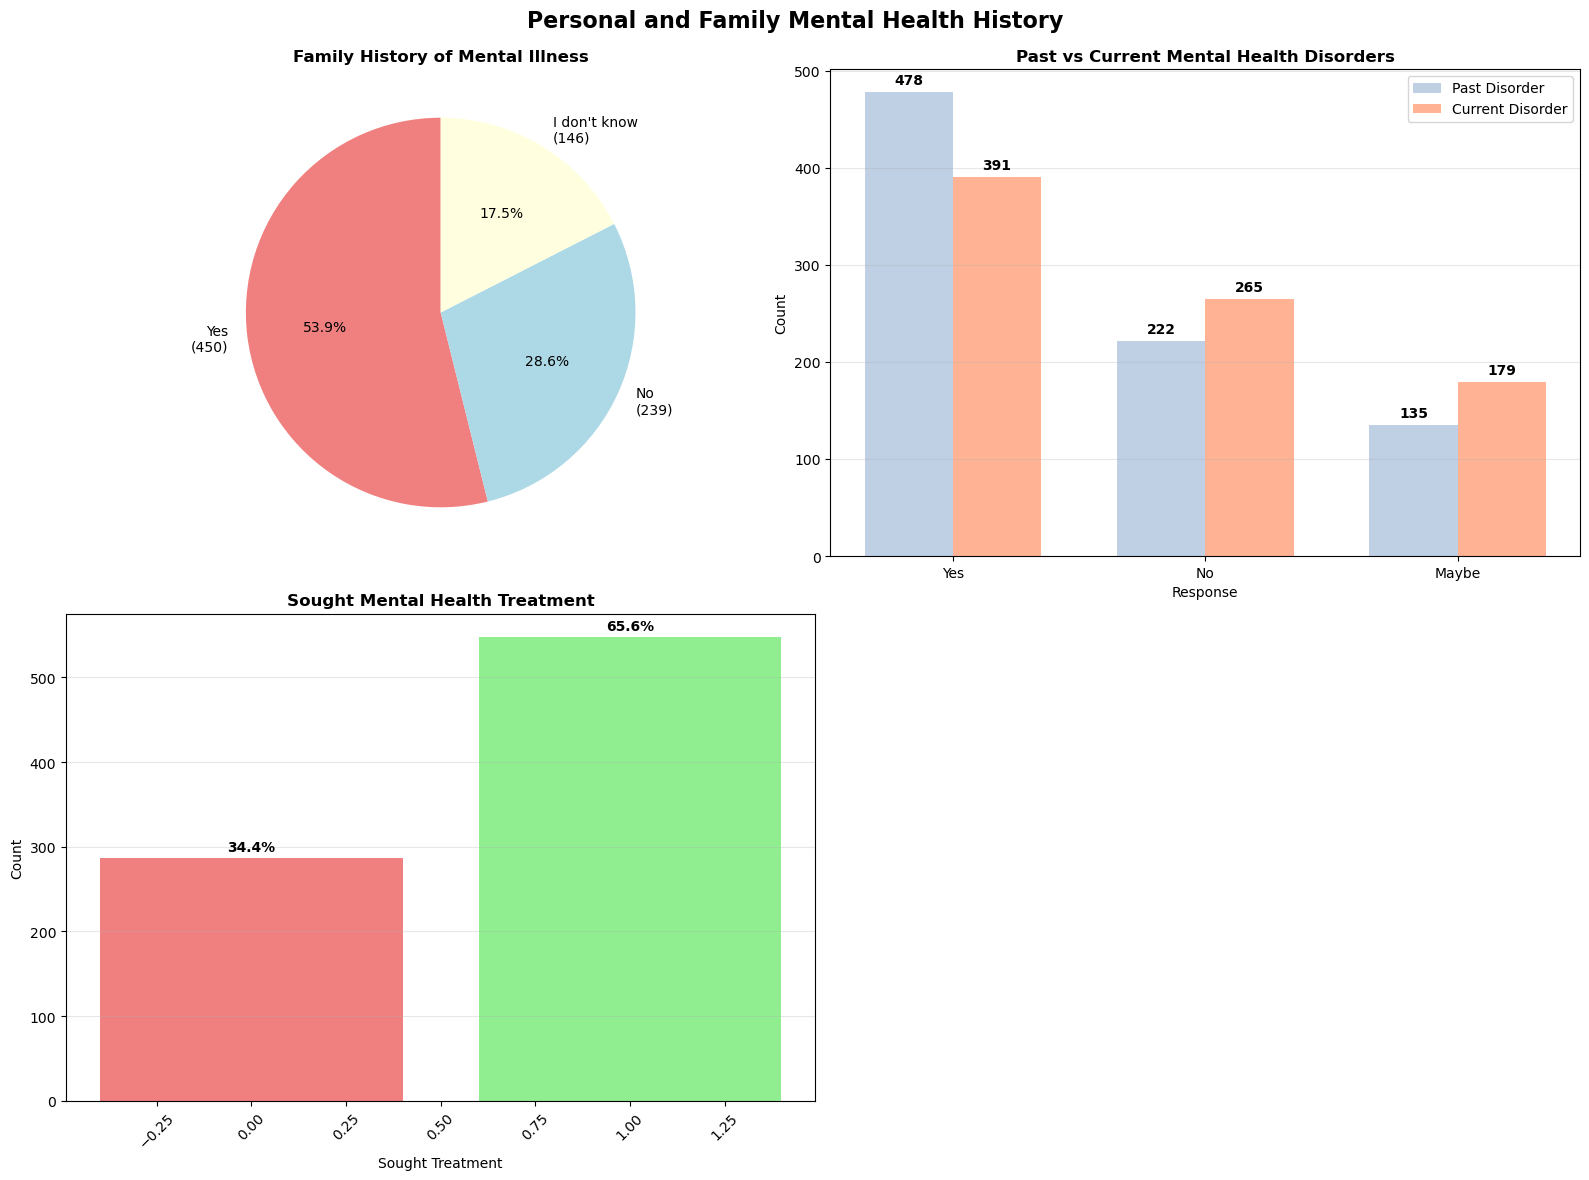


PERSONAL AND FAMILY MENTAL HEALTH HISTORY SUMMARY
Total respondents: 835

Family history of mental illness:
  Yes: 450 (53.9%)
  No: 239 (28.6%)

Mental health disorders:
  Past disorder: 478 (57.2%)
  Current disorder: 391 (46.8%)

Sought mental health treatment:
  1.0: 548 (65.6%)
  0.0: 287 (34.4%)

Both family history AND current disorder: 285 (34.1%)
Current disorder AND sought treatment (1.0): 359 (43.0%)


In [19]:
# Personal and Family Mental Health History

# This section explores respondents' personal and family mental health backgrounds, 
# including family history, current and past disorders, and treatment-seeking behavior.

# Set up the plotting area for mental health history
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Personal and Family Mental Health History', fontsize=16, fontweight='bold')

# 1. Family History of Mental Illness
family_history_counts = df_features['family_history_mh'].value_counts()
colors_family = ['lightcoral', 'lightblue', 'lightyellow']
pie1 = axes[0, 0].pie(family_history_counts.values, 
                      labels=[f'{label}\n({count})' for label, count in zip(family_history_counts.index, family_history_counts.values)], 
                      autopct='%1.1f%%', colors=colors_family[:len(family_history_counts)], startangle=90)
axes[0, 0].set_title('Family History of Mental Illness', fontweight='bold')

# 2. Past and Current Mental Health Disorders (Combined)
# Create a combined view of past and current disorders
past_counts = df_features['past_mh_disorder'].value_counts()
current_counts = df_features['current_mh_disorder'].value_counts()

# Prepare data for grouped bar chart
disorder_categories = ['Yes', 'No', 'Maybe']
past_values = [past_counts.get(cat, 0) for cat in disorder_categories]
current_values = [current_counts.get(cat, 0) for cat in disorder_categories]

x = np.arange(len(disorder_categories))
width = 0.35

bars1 = axes[0, 1].bar(x - width/2, past_values, width, label='Past Disorder', color='lightsteelblue', alpha=0.8)
bars2 = axes[0, 1].bar(x + width/2, current_values, width, label='Current Disorder', color='lightsalmon', alpha=0.8)

axes[0, 1].set_title('Past vs Current Mental Health Disorders', fontweight='bold')
axes[0, 1].set_xlabel('Response')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(disorder_categories)
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        if bar.get_height() > 0:
            axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
                            f'{int(bar.get_height())}', ha='center', va='bottom', fontweight='bold')

# 3. Sought Treatment for Mental Health
treatment_counts = df_features['sought_treatment'].value_counts()
colors_treatment = ['lightgreen', 'lightcoral', 'lightyellow']
bars3 = axes[1, 0].bar(treatment_counts.index, treatment_counts.values, 
                       color=colors_treatment[:len(treatment_counts)])
axes[1, 0].set_title('Sought Mental Health Treatment', fontweight='bold')
axes[1, 0].set_xlabel('Sought Treatment')
axes[1, 0].set_ylabel('Count')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(axis='y', alpha=0.3)

# Add percentage labels on bars
for bar, count in zip(bars3, treatment_counts.values):
    percentage = (count / len(df_features)) * 100
    axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
                    f'{percentage:.1f}%', ha='center', va='bottom', fontweight='bold')

# Hide the empty subplot
axes[1, 1].axis('off')

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.savefig('PERSONALMH.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics
print("\nPERSONAL AND FAMILY MENTAL HEALTH HISTORY SUMMARY")
print("="*60)
print(f"Total respondents: {len(df_features):,}")

# Family history statistics
family_yes = (df_features['family_history_mh'] == 'Yes').sum() if 'Yes' in df_features['family_history_mh'].unique() else 0
family_no = (df_features['family_history_mh'] == 'No').sum() if 'No' in df_features['family_history_mh'].unique() else 0
print(f"\nFamily history of mental illness:")
print(f"  Yes: {family_yes:,} ({family_yes/len(df_features)*100:.1f}%)")
print(f"  No: {family_no:,} ({family_no/len(df_features)*100:.1f}%)")

# Past vs current disorder comparison
past_yes = (df_features['past_mh_disorder'] == 'Yes').sum() if 'Yes' in df_features['past_mh_disorder'].unique() else 0
current_yes = (df_features['current_mh_disorder'] == 'Yes').sum() if 'Yes' in df_features['current_mh_disorder'].unique() else 0
print(f"\nMental health disorders:")
print(f"  Past disorder: {past_yes:,} ({past_yes/len(df_features)*100:.1f}%)")
print(f"  Current disorder: {current_yes:,} ({current_yes/len(df_features)*100:.1f}%)")

# Treatment seeking
print(f"\nSought mental health treatment:")
treatment_counts_summary = df_features['sought_treatment'].value_counts()
for category, count in treatment_counts_summary.items():
    percentage = (count / len(df_features)) * 100
    print(f"  {category}: {count:,} ({percentage:.1f}%)")

# Cross-tabulation insights
if family_yes > 0 and current_yes > 0:
    family_and_current = ((df_features['family_history_mh'] == 'Yes') & 
                         (df_features['current_mh_disorder'] == 'Yes')).sum()
    print(f"\nBoth family history AND current disorder: {family_and_current:,} ({family_and_current/len(df_features)*100:.1f}%)")

# For treatment cross-tabulation, use the actual values from the treatment column
treatment_positive_values = treatment_counts_summary.index[0]  # Get the most common value (likely the positive response)
if current_yes > 0:
    treatment_and_current = ((df_features['sought_treatment'] == treatment_positive_values) & 
                            (df_features['current_mh_disorder'] == 'Yes')).sum()
    print(f"Current disorder AND sought treatment ({treatment_positive_values}): {treatment_and_current:,} ({treatment_and_current/len(df_features)*100:.1f}%)")

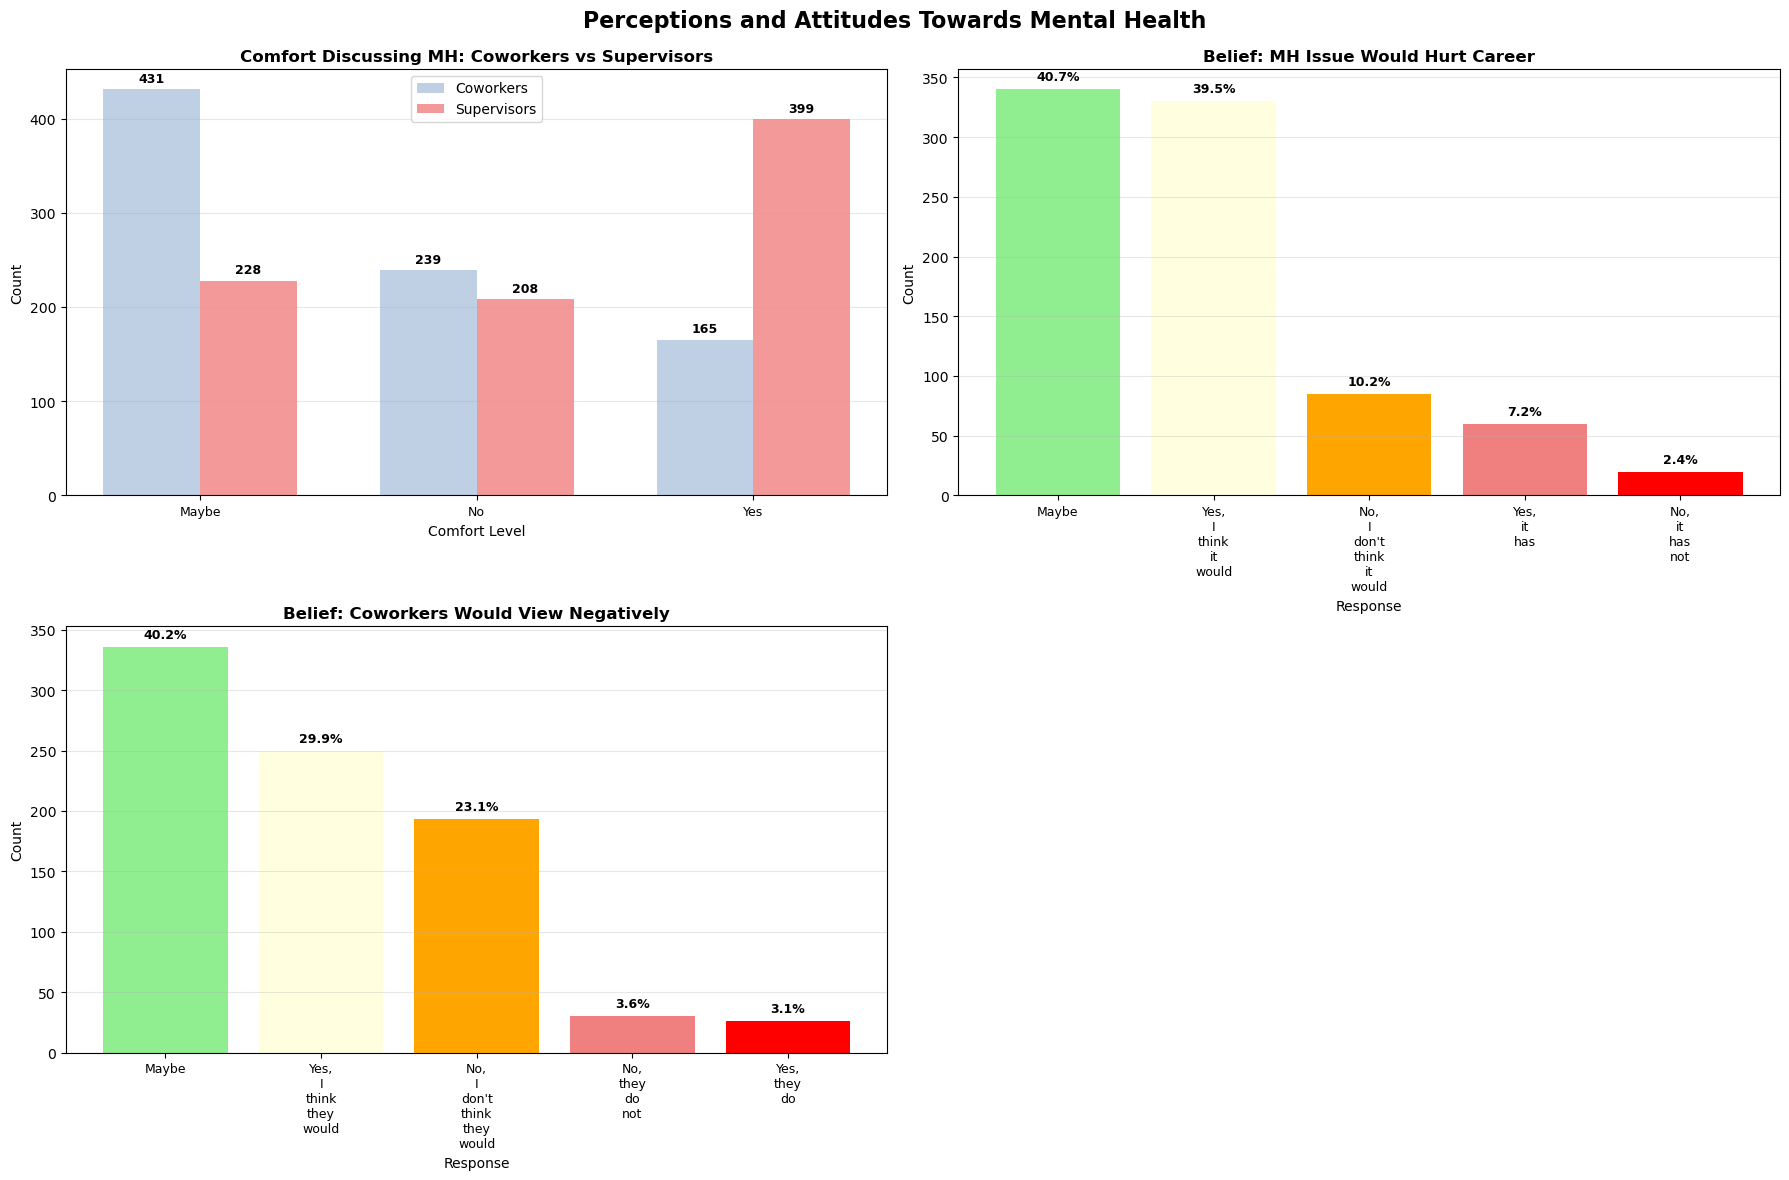


PERCEPTIONS AND ATTITUDES TOWARDS MENTAL HEALTH SUMMARY
Total respondents: 835

Comfort discussing mental health:
With coworkers:
  Maybe: 431 (51.6%)
  No: 239 (28.6%)
  Yes: 165 (19.8%)

With supervisors:
  Yes: 399 (47.8%)
  Maybe: 228 (27.3%)
  No: 208 (24.9%)

Belief that MH issue would hurt career:
  Maybe: 340 (40.7%)
  Yes, I think it would: 330 (39.5%)
  No, I don't think it would: 85 (10.2%)
  Yes, it has: 60 (7.2%)
  No, it has not: 20 (2.4%)

Belief that coworkers would view negatively:
  Maybe: 336 (40.2%)
  Yes, I think they would: 250 (29.9%)
  No, I don't think they would: 193 (23.1%)
  No, they do not: 30 (3.6%)
  Yes, they do: 26 (3.1%)


In [20]:
# Perceptions and Attitudes Towards Mental Health

# This section examines respondents' perceptions and attitudes towards mental health discussions 
# and potential consequences in the workplace, including comfort levels and career concerns.

# Set up the plotting area for mental health perceptions and attitudes
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Perceptions and Attitudes Towards Mental Health', fontsize=16, fontweight='bold')

# 1. Coworker vs Supervisor Mental Health Comfort (Combined)
coworker_counts = df_features['coworker_mh_comfort'].value_counts()
supervisor_counts = df_features['supervisor_mh_comfort'].value_counts()

# Get all unique categories from both columns
all_categories = sorted(list(set(coworker_counts.index.tolist() + supervisor_counts.index.tolist())))
coworker_values = [coworker_counts.get(cat, 0) for cat in all_categories]
supervisor_values = [supervisor_counts.get(cat, 0) for cat in all_categories]

x = np.arange(len(all_categories))
width = 0.35

bars1 = axes[0, 0].bar(x - width/2, coworker_values, width, label='Coworkers', color='lightsteelblue', alpha=0.8)
bars2 = axes[0, 0].bar(x + width/2, supervisor_values, width, label='Supervisors', color='lightcoral', alpha=0.8)

axes[0, 0].set_title('Comfort Discussing MH: Coworkers vs Supervisors', fontweight='bold')
axes[0, 0].set_xlabel('Comfort Level')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels([label.replace(' ', '\n') for label in all_categories], fontsize=9)
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        if bar.get_height() > 0:
            axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
                            f'{int(bar.get_height())}', ha='center', va='bottom', fontweight='bold', fontsize=9)

# 2. Mental Health Impact on Career
career_counts = df_features['mh_hurt_career'].value_counts()
colors_career = ['lightgreen', 'lightyellow', 'orange', 'lightcoral', 'red']
bars3 = axes[0, 1].bar(range(len(career_counts)), career_counts.values, 
                       color=colors_career[:len(career_counts)])
axes[0, 1].set_title('Belief: MH Issue Would Hurt Career', fontweight='bold')
axes[0, 1].set_xlabel('Response')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_xticks(range(len(career_counts)))
axes[0, 1].set_xticklabels([label.replace(' ', '\n') for label in career_counts.index], fontsize=9)
axes[0, 1].grid(axis='y', alpha=0.3)

# Add percentage labels on bars
for bar, count in zip(bars3, career_counts.values):
    percentage = (count / len(df_features)) * 100
    axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
                    f'{percentage:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=9)

# 3. Coworkers' Negative View
coworkers_view_counts = df_features['coworkers_negative_view'].value_counts()
colors_view = ['lightgreen', 'lightyellow', 'orange', 'lightcoral', 'red']
bars4 = axes[1, 0].bar(range(len(coworkers_view_counts)), coworkers_view_counts.values, 
                       color=colors_view[:len(coworkers_view_counts)])
axes[1, 0].set_title('Belief: Coworkers Would View Negatively', fontweight='bold')
axes[1, 0].set_xlabel('Response')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_xticks(range(len(coworkers_view_counts)))
axes[1, 0].set_xticklabels([label.replace(' ', '\n') for label in coworkers_view_counts.index], fontsize=9)
axes[1, 0].grid(axis='y', alpha=0.3)

# Add percentage labels on bars
for bar, count in zip(bars4, coworkers_view_counts.values):
    percentage = (count / len(df_features)) * 100
    axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
                    f'{percentage:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=9)

# Hide the empty subplot
axes[1, 1].axis('off')

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.savefig('PERCEPTIONSMH.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics
print("\nPERCEPTIONS AND ATTITUDES TOWARDS MENTAL HEALTH SUMMARY")
print("="*65)
print(f"Total respondents: {len(df_features):,}")

# Comfort level comparison
print(f"\nComfort discussing mental health:")
print(f"With coworkers:")
for category, count in coworker_counts.items():
    percentage = (count / len(df_features)) * 100
    print(f"  {category}: {count:,} ({percentage:.1f}%)")

print(f"\nWith supervisors:")
for category, count in supervisor_counts.items():
    percentage = (count / len(df_features)) * 100
    print(f"  {category}: {count:,} ({percentage:.1f}%)")

# Career impact beliefs
print(f"\nBelief that MH issue would hurt career:")
for category, count in career_counts.items():
    percentage = (count / len(df_features)) * 100
    print(f"  {category}: {count:,} ({percentage:.1f}%)")

# Coworkers' negative view beliefs
print(f"\nBelief that coworkers would view negatively:")
for category, count in coworkers_view_counts.items():
    percentage = (count / len(df_features)) * 100
    print(f"  {category}: {count:,} ({percentage:.1f}%)")

## Encoding attributes

This section converts categorical variables to numeric format using a two-step approach that preserves meaningful relationships. First, ordinal encoding is applied to variables with natural ordering (e.g., company_size from "1-5" to "More than 1000", leave_difficulty from "Very easy" to "Very difficult") to maintain their hierarchical structure, which is crucial for distance-based clustering algorithms. Second, label encoding transforms remaining nominal categorical variables to numeric values. This method ensures that ordinal relationships are preserved where meaningful while making all features numeric for machine learning compatibility.

In [21]:
print("CATEGORICAL VARIABLE ENCODING")
print("="*50)

# First, let's examine the unique values in key categorical columns to understand their structure
key_columns_to_examine = [
    'company_size', 'leave_difficulty', 'mh_hurt_career', 
    'coworkers_negative_view', 'family_sharing_willingness',
    'work_interference_treated', 'work_interference_untreated', 'work_remotely'
]

print("Examining ordinal categorical patterns:")
for col in key_columns_to_examine:
    if col in df_features.columns:
        unique_vals = df_features[col].unique()
        print(f"\n{col}:")
        print(f"  Values: {unique_vals}")
        print(f"  Count: {len(unique_vals)}")

CATEGORICAL VARIABLE ENCODING
Examining ordinal categorical patterns:

company_size:
  Values: ['6-25' '26-100' 'More than 1000' '100-500' '500-1000' '1-5']
  Count: 6

leave_difficulty:
  Values: ['Somewhat easy' 'Neither easy nor difficult' 'Very easy' 'Very difficult'
 'Somewhat difficult' "I don't know"]
  Count: 6

mh_hurt_career:
  Values: ["No, I don't think it would" 'Yes, I think it would' 'Maybe'
 'No, it has not' 'Yes, it has']
  Count: 5

coworkers_negative_view:
  Values: ["No, I don't think they would" 'Maybe' 'Yes, they do'
 'Yes, I think they would' 'No, they do not']
  Count: 5

family_sharing_willingness:
  Values: ['Somewhat open' 'Not applicable to me (I do not have a mental illness)'
 'Very open' 'Not open at all' 'Neutral' 'Somewhat not open']
  Count: 6

work_interference_treated:
  Values: ['Rarely' 'Sometimes' 'Not applicable to me' 'Never' 'Often']
  Count: 5

work_interference_untreated:
  Values: ['Sometimes' 'Not applicable to me' 'Often' 'Rarely' 'Never']


In [22]:
# Define ordinal mappings with proper order (low to high)
ordinal_mappings = {
    "company_size": {
        "1-5": 1,
        "6-25": 2,
        "26-100": 3,
        "100-500": 4,
        "500-1000": 5,
        "More than 1000": 6
    },
    "leave_difficulty": {
        "Very easy": 1,
        "Somewhat easy": 2,
        "Neither easy nor difficult": 3,
        "Somewhat difficult": 4,
        "Very difficult": 5,
        "I don't know": 6
    },
    "mh_hurt_career": {
        "No, I don't think it would": 1,
        "No, it has not": 2,
        "Maybe": 3,
        "Yes, I think it would": 4,
        "Yes, it has": 5
    },
    "coworkers_negative_view": {
        "No, they do not": 1,
        "No, I don't think they would": 2,
        "Maybe": 3,
        "Yes, I think they would": 4,
        "Yes, they do": 5
    },
    "family_sharing_willingness": {
        "Not applicable to me (I do not have a mental illness)": 0,
        "Not open at all": 1,
        "Somewhat not open": 2,
        "Neutral": 3,
        "Somewhat open": 4,
        "Very open": 5
    },
    "work_interference_treated": {
        "Not applicable to me": 0,
        "Never": 1,
        "Rarely": 2,
        "Sometimes": 3,
        "Often": 4
    },
    "work_interference_untreated": {
        "Not applicable to me": 0,
        "Never": 1,
        "Rarely": 2,
        "Sometimes": 3,
        "Often": 4
    },
    "work_remotely": {
        "Never": 1,
        "Sometimes": 2,
        "Always": 3
    }
}

# Apply ordinal encodings
df_encoded = df_features.copy()

print("\nApplying ordinal encodings:")
for col, mapping in ordinal_mappings.items():
    if col in df_encoded.columns:
        # Check if all values in the column exist in our mapping
        unique_vals = df_encoded[col].unique()
        missing_mappings = [val for val in unique_vals if val not in mapping]
        
        if missing_mappings:
            print(f"  ⚠️  {col}: Missing mappings for {missing_mappings}")
        else:
            df_encoded[col] = df_encoded[col].map(mapping)
            print(f"  ✅ {col}: Encoded to numeric (1-{max(mapping.values())})")
    else:
        print(f"  ❌ {col}: Column not found")


Applying ordinal encodings:
  ✅ company_size: Encoded to numeric (1-6)
  ✅ leave_difficulty: Encoded to numeric (1-6)
  ✅ mh_hurt_career: Encoded to numeric (1-5)
  ✅ coworkers_negative_view: Encoded to numeric (1-5)
  ✅ family_sharing_willingness: Encoded to numeric (1-5)
  ✅ work_interference_treated: Encoded to numeric (1-4)
  ✅ work_interference_untreated: Encoded to numeric (1-4)
  ✅ work_remotely: Encoded to numeric (1-3)


In [23]:
# Handle remaining categorical variables with Label Encoding
from sklearn.preprocessing import LabelEncoder

# Identify remaining categorical columns (non-numeric)
remaining_categorical = df_encoded.select_dtypes(include=['object']).columns.tolist()

print(f"\nRemaining categorical columns to encode: {len(remaining_categorical)}")

# Apply label encoding to remaining categorical columns
label_encoders = {}
for col in remaining_categorical:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le
    n_categories = len(le.classes_)
    print(f"  ✅ {col}: Label encoded ({n_categories} categories)")

print(f"\nFinal dataset info:")
print(f"Shape: {df_encoded.shape}")
print(f"All numeric: {df_encoded.select_dtypes(include=[np.number]).shape[1] == df_encoded.shape[1]}")

# Check data types
print(f"\nData types after encoding:")
print(df_encoded.dtypes.value_counts())


Remaining categorical columns to encode: 30
  ✅ mh_benefits: Label encoded (4 categories)
  ✅ mh_coverage_knowledge: Label encoded (3 categories)
  ✅ employer_mh_discussion: Label encoded (3 categories)
  ✅ employer_mh_resources: Label encoded (3 categories)
  ✅ anonymity_protected: Label encoded (3 categories)
  ✅ employer_mh_consequences: Label encoded (3 categories)
  ✅ employer_ph_consequences: Label encoded (3 categories)
  ✅ coworker_mh_comfort: Label encoded (3 categories)
  ✅ supervisor_mh_comfort: Label encoded (3 categories)
  ✅ mh_ph_equality: Label encoded (3 categories)
  ✅ observed_consequences: Label encoded (2 categories)
  ✅ prev_mh_benefits: Label encoded (4 categories)
  ✅ prev_mh_coverage_knowledge: Label encoded (4 categories)
  ✅ prev_employer_mh_discussion: Label encoded (4 categories)
  ✅ prev_employer_mh_resources: Label encoded (3 categories)
  ✅ prev_anonymity_protected: Label encoded (4 categories)
  ✅ prev_employer_mh_consequences: Label encoded (4 categor

In [24]:
# Print the dimensions of the cleaned dataframe (rows, columns)
print("Shape:", df_encoded.shape)
# Display detailed information about the dataframe (columns, data types, non-null values)
print("\nInfo:")
# Displays a concise summary of the DataFrame.
df_encoded.info()

Shape: (835, 43)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 835 entries, 0 to 834
Data columns (total 43 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   self_employed                   835 non-null    float64
 1   company_size                    835 non-null    int64  
 2   is_tech_company                 835 non-null    float64
 3   mh_benefits                     835 non-null    int32  
 4   mh_coverage_knowledge           835 non-null    int32  
 5   employer_mh_discussion          835 non-null    int32  
 6   employer_mh_resources           835 non-null    int32  
 7   anonymity_protected             835 non-null    int32  
 8   leave_difficulty                835 non-null    int64  
 9   employer_mh_consequences        835 non-null    int32  
 10  employer_ph_consequences        835 non-null    int32  
 11  coworker_mh_comfort             835 non-null    int32  
 12  supervisor_m

## Feature scaling for clustering

This section applies StandardScaler to normalize all features to have mean=0 and standard deviation=1, which is essential for distance-based clustering algorithms. Without scaling, features with larger ranges (like age: 18-80) would dominate the distance calculations over binary features (0-1), leading to biased clusters. StandardScaler is preferred over MinMaxScaler for clustering because it better handles outliers and preserves the original distribution shape while ensuring all features contribute equally to cluster formation. Additionally, this section includes a comprehensive correlation matrix visualization to assess feature independence and identify potential multicollinearity issues. The correlation analysis examines all pairwise relationships between the 43 features, providing insights into feature redundancy and validating that the dataset is well-prepared for clustering algorithms with appropriately independent variables.

In [25]:
print("FEATURE SCALING FOR CLUSTERING")
print("="*50)

# Check current data ranges to understand scaling needs
print("Current data ranges (first 10 columns):")
sample_cols = df_encoded.columns[:10]
for col in sample_cols:
    min_val, max_val = df_encoded[col].min(), df_encoded[col].max()
    print(f"{col}: {min_val} to {max_val}")

print(f"\nAge range: {df_encoded['age_clean'].min()} to {df_encoded['age_clean'].max()}")

# Apply StandardScaler (better for clustering algorithms)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaled = pd.DataFrame(
    scaler.fit_transform(df_encoded),
    columns=df_encoded.columns,
    index=df_encoded.index
)

print(f"\nScaling completed:")
print(f"✅ All features standardized (mean=0, std=1)")
print(f"Dataset shape: {df_scaled.shape}")

FEATURE SCALING FOR CLUSTERING
Current data ranges (first 10 columns):
self_employed: 0.0 to 1.0
company_size: 1 to 6
is_tech_company: 0.0 to 1.0
mh_benefits: 0 to 3
mh_coverage_knowledge: 0 to 2
employer_mh_discussion: 0 to 2
employer_mh_resources: 0 to 2
anonymity_protected: 0 to 2
leave_difficulty: 1 to 6
employer_mh_consequences: 0 to 2

Age range: 19.0 to 74.0

Scaling completed:
✅ All features standardized (mean=0, std=1)
Dataset shape: (835, 43)


In [26]:
# Verify scaling worked correctly
print("\nSCALING VERIFICATION")
print("="*30)

# Check means and standard deviations
print("Sample column statistics after scaling:")
for col in df_scaled.columns[:5]:
    mean_val = df_scaled[col].mean()
    std_val = df_scaled[col].std()
    print(f"{col}: mean={mean_val:.3f}, std={std_val:.3f}")

print(f"\nOverall statistics:")
print(f"Mean of all columns: {df_scaled.mean().mean():.6f}")
print(f"Std of all columns: {df_scaled.std().mean():.3f}")


SCALING VERIFICATION
Sample column statistics after scaling:
self_employed: mean=0.000, std=1.001
company_size: mean=0.000, std=1.001
is_tech_company: mean=0.000, std=1.001
mh_benefits: mean=-0.000, std=1.001
mh_coverage_knowledge: mean=0.000, std=1.001

Overall statistics:
Mean of all columns: -0.000000
Std of all columns: 1.001



CORRELATION MATRIX VISUALIZATION


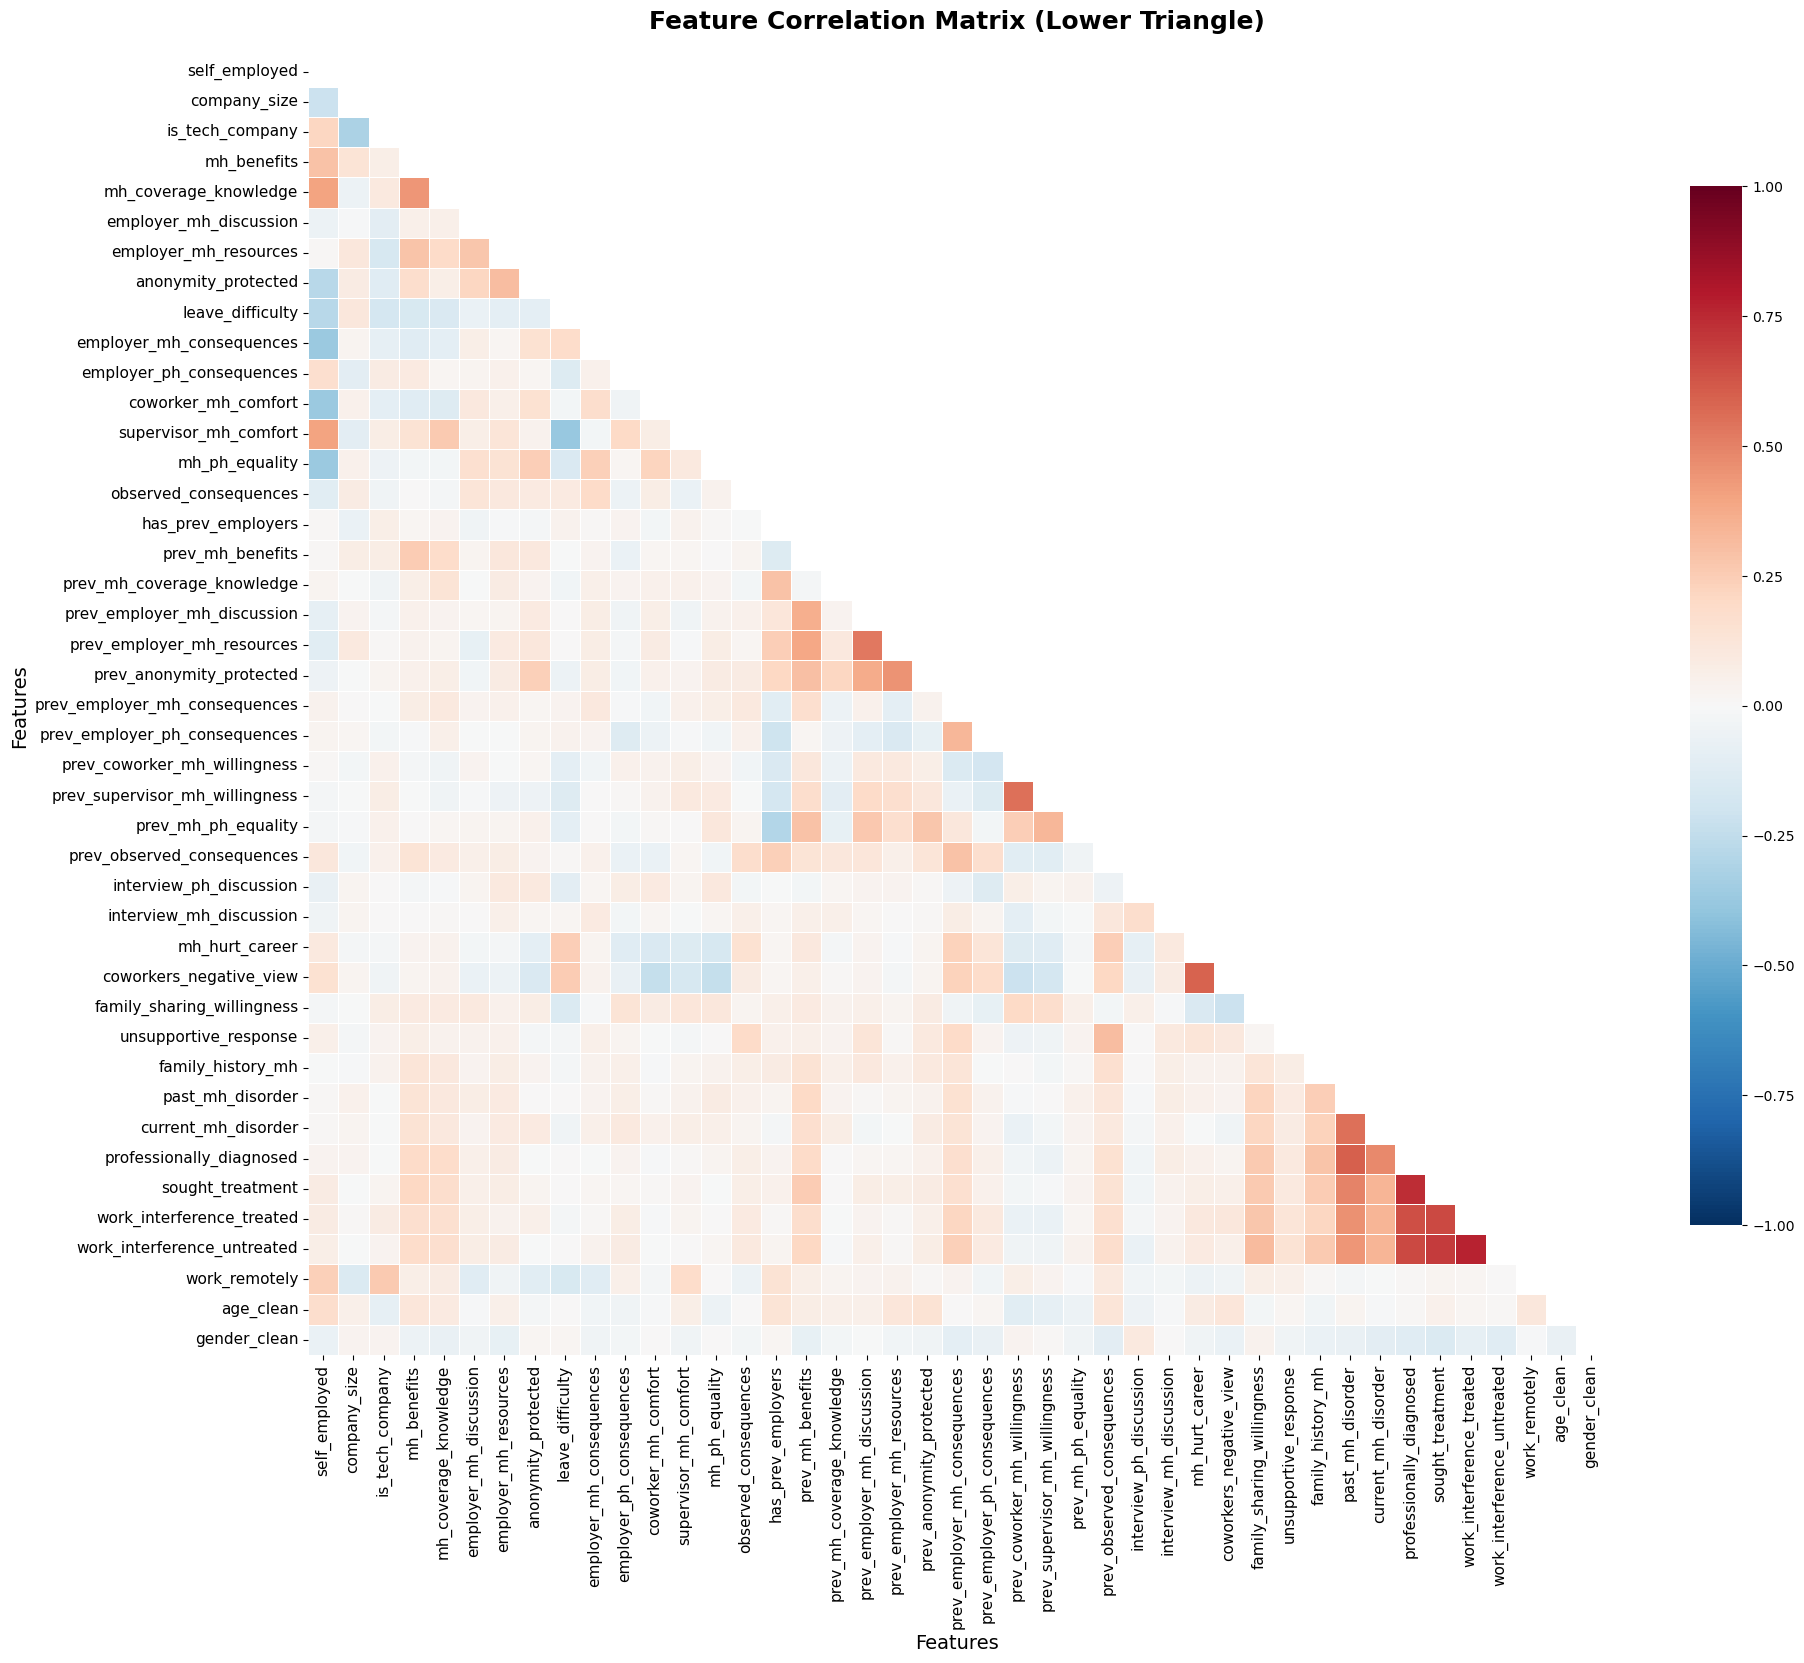


📊 CORRELATION ANALYSIS SUMMARY:
Total correlation pairs analyzed: 903
Mean absolute correlation: 0.089
Max correlation: 0.767
Min correlation: -0.381

Correlation strength distribution:
  Very High (|r| ≥ 0.8): 0 pairs (0.0%)
  High (0.5 ≤ |r| < 0.8): 11 pairs (1.2%)
  Moderate (0.3 ≤ |r| < 0.5): 24 pairs (2.7%)
  Low (|r| < 0.3): 868 pairs (96.1%)

🔝 TOP 10 HIGHEST CORRELATIONS:
------------------------------------------------------------
work_interference_treated    ↔ work_interference_untreat... |  0.767
professionally_diagnosed     ↔ sought_treatment             |  0.735
sought_treatment             ↔ work_interference_untreat... |  0.697
professionally_diagnosed     ↔ work_interference_untreat... |  0.663
sought_treatment             ↔ work_interference_treated    |  0.656
professionally_diagnosed     ↔ work_interference_treated    |  0.643
past_mh_disorder             ↔ professionally_diagnosed     |  0.594
mh_hurt_career               ↔ coworkers_negative_view      |  0.588
pre

In [27]:
# Create correlation matrix visualization
print("\nCORRELATION MATRIX VISUALIZATION")
print("="*50)

# Calculate correlation matrix
corr_matrix = df_scaled.corr()

# Create a single, clean correlation matrix plot
plt.figure(figsize=(20, 16))

# Create mask for upper triangle to avoid redundancy
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Create the heatmap
sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='RdBu_r', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1)

plt.title('Feature Correlation Matrix (Lower Triangle)', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Features', fontsize=14)
plt.ylabel('Features', fontsize=14)

# Improve label readability
plt.xticks(rotation=90, fontsize=11)
plt.yticks(rotation=0, fontsize=11)

# Adjust layout to give more space for labels
plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
plt.show()

# Summary statistics about correlations
print(f"\n📊 CORRELATION ANALYSIS SUMMARY:")
print("="*40)

# Get upper triangle values (excluding diagonal)
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
correlations = upper_triangle.stack().values

print(f"Total correlation pairs analyzed: {len(correlations):,}")
print(f"Mean absolute correlation: {np.abs(correlations).mean():.3f}")
print(f"Max correlation: {correlations.max():.3f}")
print(f"Min correlation: {correlations.min():.3f}")

# Count correlations by strength
very_high = np.sum(np.abs(correlations) >= 0.8)
high = np.sum((np.abs(correlations) >= 0.5) & (np.abs(correlations) < 0.8))
moderate = np.sum((np.abs(correlations) >= 0.3) & (np.abs(correlations) < 0.5))
low = np.sum(np.abs(correlations) < 0.3)

print(f"\nCorrelation strength distribution:")
print(f"  Very High (|r| ≥ 0.8): {very_high} pairs ({very_high/len(correlations)*100:.1f}%)")
print(f"  High (0.5 ≤ |r| < 0.8): {high} pairs ({high/len(correlations)*100:.1f}%)")
print(f"  Moderate (0.3 ≤ |r| < 0.5): {moderate} pairs ({moderate/len(correlations)*100:.1f}%)")
print(f"  Low (|r| < 0.3): {low} pairs ({low/len(correlations)*100:.1f}%)")

if very_high > 0:
    print(f"\n⚠️  {very_high} pairs with very high correlation may indicate redundancy")

# Find and display the top 10 highest correlations
print(f"\n🔝 TOP 10 HIGHEST CORRELATIONS:")
print("-" * 60)

# Get correlation pairs with their values
corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_val = corr_matrix.iloc[i, j]
        corr_pairs.append({
            'Feature_1': corr_matrix.columns[i],
            'Feature_2': corr_matrix.columns[j],
            'Correlation': corr_val
        })

# Sort by absolute correlation value
corr_pairs_df = pd.DataFrame(corr_pairs)
corr_pairs_df['Abs_Correlation'] = np.abs(corr_pairs_df['Correlation'])
top_corr = corr_pairs_df.nlargest(10, 'Abs_Correlation')

for idx, row in top_corr.iterrows():
    f1 = row['Feature_1'][:25] + "..." if len(row['Feature_1']) > 25 else row['Feature_1']
    f2 = row['Feature_2'][:25] + "..." if len(row['Feature_2']) > 25 else row['Feature_2']
    print(f"{f1:<28} ↔ {f2:<28} | {row['Correlation']:6.3f}")

print(f"\n✅ Correlation analysis complete.")
print("="*50)

## Downloading the cleaned and preprocessed data

This section creates the final feature matrix for clustering analysis and saves the processed dataset in multiple formats for different use cases. The code exports the data as CSV/Excel files for general analysis, NumPy array for machine learning algorithms, and a text file containing feature names for reference. It also provides a comprehensive summary showing the complete preprocessing pipeline transformation from 1,433 raw survey responses to a clean, standardized dataset of 835 samples × 43 features, ready for clustering algorithms.

In [28]:
# Create final feature matrix for clustering
X = df_scaled.values
feature_names = df_scaled.columns.tolist()

print(f"\nFINAL CLUSTERING DATASET")
print("="*40)
print(f"Feature matrix shape: {X.shape}")
print(f"Number of samples: {X.shape[0]}")
print(f"Number of features: {X.shape[1]}")
print(f"Data type: {X.dtype}")
print(f"No missing values: {not np.isnan(X).any()}")

# Save the final processed datasets
df_scaled.to_csv("mental_health_scaled_final.csv", index=False)
df_scaled.to_excel("mental_health_scaled_final.xlsx", index=False)
np.save("mental_health_features_matrix.npy", X)

# Also save feature names for reference
with open("feature_names.txt", "w") as f:
    for name in feature_names:
        f.write(f"{name}\n")

print(f"\n✅ Saved files:")
print(f"  - mental_health_scaled_final.csv (DataFrame)")
print(f"  - mental_health_features_matrix.npy (NumPy array)")
print(f"  - feature_names.txt (feature reference)")


FINAL CLUSTERING DATASET
Feature matrix shape: (835, 43)
Number of samples: 835
Number of features: 43
Data type: float64
No missing values: True

✅ Saved files:
  - mental_health_scaled_final.csv (DataFrame)
  - mental_health_features_matrix.npy (NumPy array)
  - feature_names.txt (feature reference)


In [29]:
# Summary of preprocessing pipeline
print(f"\nPREPROCESSING PIPELINE SUMMARY")
print("="*50)
print(f"1. Started with: 1,433 responses, 63 columns")
print(f"2. Geographic filtering (US only): 837 responses")
print(f"3. Age filtering (18-80): 835 responses")
print(f"4. Feature selection: 43 relevant columns")
print(f"5. Missing value imputation: 0 missing values")
print(f"6. Categorical encoding: All numeric")
print(f"7. Feature scaling: Standardized")
print(f"8. Final dataset: {X.shape[0]} samples × {X.shape[1]} features")

print(f"\n🎯 READY FOR CLUSTERING:")
print(f"   ✅ K-Means Clustering")
print(f"   ✅ Agglomerative Clustering") 
print(f"   ✅ Gaussian Mixture Models")


PREPROCESSING PIPELINE SUMMARY
1. Started with: 1,433 responses, 63 columns
2. Geographic filtering (US only): 837 responses
3. Age filtering (18-80): 835 responses
4. Feature selection: 43 relevant columns
5. Missing value imputation: 0 missing values
6. Categorical encoding: All numeric
7. Feature scaling: Standardized
8. Final dataset: 835 samples × 43 features

🎯 READY FOR CLUSTERING:
   ✅ K-Means Clustering
   ✅ Agglomerative Clustering
   ✅ Gaussian Mixture Models
